# 1. Carregando bibliotecas

A biblioteca principal é o **City2Graph**. A partir dessa biblioteca é possível fazer o download de todos os temas (places, segments, connectors, buiding).

Nesse script, serão baixados os temas **SEGMENTS** e **CONNECTORS** que serão as arestas e nós do nosso grafo.

In [1]:
# Geospatial data processing
import numpy as np
import pandas as pd
import json
import geopandas as gpd
import networkx as nx
from shapely import Point
import time


# Mapping and visualization
import contextily as ctx
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from matplotlib.lines import Line2D


# Network analysis
#import osmnx as ox

# The star of the show: city2graph for transportation network analysis
import city2graph as c2g

# Configure matplotlib for publication-quality visualizations
plt.rcParams['figure.figsize'] = (15, 12)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 11
plt.style.use('ggplot')
#plt.style.use('default')  # Clean default style instead of ggplot

print("All dependencies loaded successfully!")
print(f"city2graph version: {c2g.__version__ if hasattr(c2g, '__version__') else 'development'}")

All dependencies loaded successfully!
city2graph version: 0.1.6


In [5]:
# Função para obter o tipo de geometria e a contagem de feições

def check_geom(gdf):
    geom_types = gdf["geometry"].geom_type.value_counts()
    print("\n🔍 Tipo(s) da Geometria da camada:")
    for geom_type, count in geom_types.items():
        print(f"   • {geom_type}: {count:,}")

# 2. Carregando dados vetorias contendo a delimitação da área de estudo

In [6]:
# Carregar arquivos de referência da pesquisa
area_estudo = gpd.read_file("dados/zona_urbana/area_estudo_zu.geojson").to_crs(epsg=31983)
bbox_ae = [-42.865397,-5.231538,-42.662587,-4.955767]

area_estudo_buffer3km = gpd.read_file("dados/zona_urbana/area_estudo_zu_buffer3km.geojson").to_crs(epsg=31983)
bbox_ae_3km = [-42.863200,-5.259269, -42.626205, -4.929381]

In [7]:
# Calcular os valores de área e atualizar caso exista.
area_estudo["area_m2"] = area_estudo.area #apenas atualiza
area_estudo.insert(loc=len(area_estudo.columns) - 1, column="area_km2", value=area_estudo.area / 1000000) #cria uma nova coluna
print(f"ÁREA DE ESTUDO (Km²) = {area_estudo["area_km2"]}")

area_estudo_buffer3km["area_m2"] = area_estudo_buffer3km.area # apenas atualiza
area_estudo_buffer3km["area_km2"] = area_estudo_buffer3km.area/1000000 # apenas atualiza
print(f"ÁREA DE ESTUDO BUFFER 3KM (Km²) = {area_estudo_buffer3km["area_km2"]}")

ÁREA DE ESTUDO (Km²) = 0    279.000697
Name: area_km2, dtype: float64
ÁREA DE ESTUDO BUFFER 3KM (Km²) = 0    537.453272
Name: area_km2, dtype: float64


# 3. Baixando e Carregando dados Overture Maps

## 3.1 Essa etapa só deve ser executada, caso queira ter acesso aos dados mais recentes da Overture.

In [ ]:
# Download data from Overture Maps (uncomment to download fresh data)
# This downloads building footprints, road segments, and connectors for Teresina city centre

path_dados_intermediario = "dados/overturemaps/intermediarios/"
path_dados_finais = "/dados/overturemaps/finais/"

city2graph.load_overture_data(
    area=bbox_ae_3km,
    types=["segment", "connector"],
    output_dir=path_dados_intermediario,
    prefix="teresina_bbox_ae3km_",
    save_to_file=True,
    return_data=False
)

print("Dados baixados foi concluído.")

Dados baixados foi concluído.


## 3.2 Após download na etapa acima, carregue os dados localmente.

In [8]:
# Load the downloaded GeoJSON files
# Convert to UTM 23 Sul Grade (EPSG:31983) for accurate distance calculations
segments_gdf_bboxae3km = gpd.read_file("./dados/overturemaps/intermediarios/teresina_AE3km_script_segment.geojson").to_crs(epsg=31983)
connectors_gdf_bboxae3km = gpd.read_file("./dados/overturemaps/intermediarios/teresina_AE3km_script_connector.geojson").to_crs(epsg=31983)
ubs_gdf_ae = gpd.read_file("./dados/semplam/ubs_zu.geojson").to_crs(epsg=31983)

print("✅ Dados Carregados com Sucesso!")
print("📊 Resumo do Conjunto de Dados:")

print(f"   • UBS: {len(ubs_gdf_ae):,}")
print(f"   • Road segments: {len(segments_gdf_bboxae3km):,}")
print(f"   • Connectors: {len(connectors_gdf_bboxae3km):,}")
print("\n")
print("----------- SRC ORIGNAL -----------------")

print(f"   • Área de Estudo (ZU) -> CRS ORIGINAL: {area_estudo.crs}")
print(f"   • Área de Estudo (ZU Buffer 3 km) -> CRS ORIGINAL: {area_estudo_buffer3km.crs}")
print(f"   • UBS -> CRS ORIGINAL: {ubs_gdf_ae.crs}")
print(f"   • SEGMENTS -> CRS ORIGINAL: {segments_gdf_bboxae3km.crs}")
print(f"   • CONNECTORS -> CRS ORIGINAL: {connectors_gdf_bboxae3km.crs}")

✅ Dados Carregados com Sucesso!
📊 Resumo do Conjunto de Dados:
   • UBS: 75
   • Road segments: 55,387
   • Connectors: 40,204


----------- SRC ORIGNAL -----------------
   • Área de Estudo (ZU) -> CRS ORIGINAL: EPSG:31983
   • Área de Estudo (ZU Buffer 3 km) -> CRS ORIGINAL: EPSG:31983
   • UBS -> CRS ORIGINAL: EPSG:31983
   • SEGMENTS -> CRS ORIGINAL: EPSG:31983
   • CONNECTORS -> CRS ORIGINAL: EPSG:31983


Checando o tipo da geometria das camadas

In [10]:
check_geom(ubs_gdf_ae)
check_geom(segments_gdf_bboxae3km)
check_geom(connectors_gdf_bboxae3km)


🔍 Tipo(s) da Geometria da camada:
   • Point: 75

🔍 Tipo(s) da Geometria da camada:
   • LineString: 55,387

🔍 Tipo(s) da Geometria da camada:
   • Point: 40,204


### Plotando dados iniciais

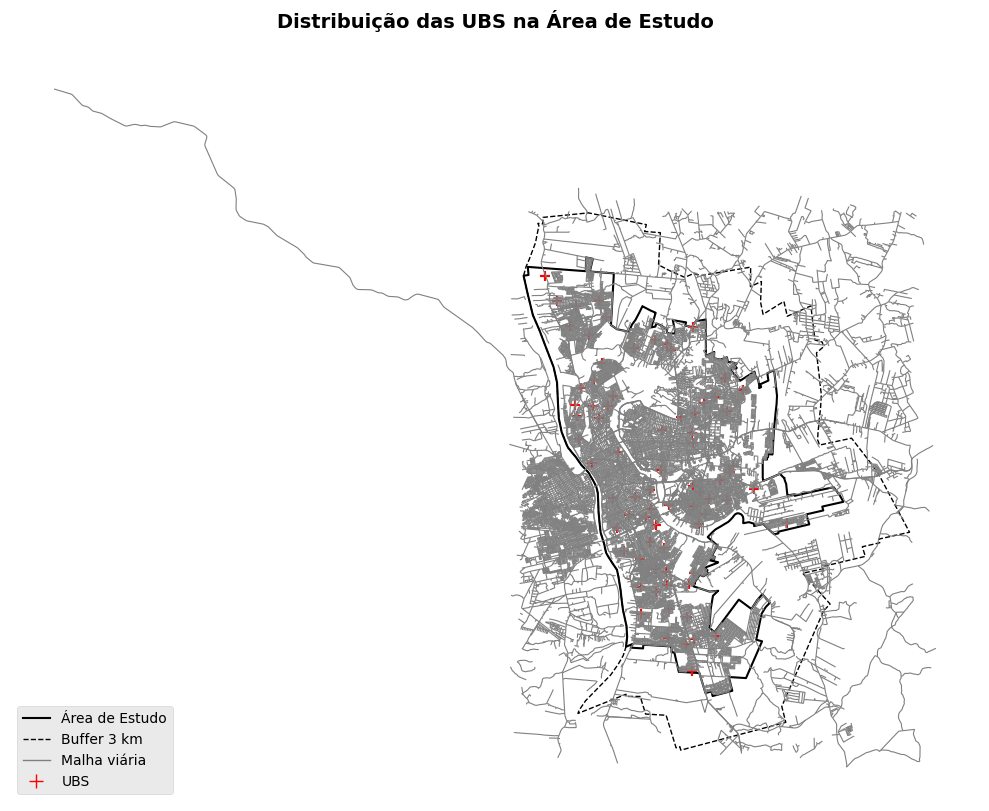

In [14]:
# --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 4️⃣ UBS — cruz vermelha 5️⃣
ubs_gdf_ae.plot(ax=ax, color='red', marker='+', markersize=50, label='UBS',)

# 1️⃣ Malha viária — linhas cinza
segments_gdf_bboxae3km.plot(ax=ax, color='gray', linewidth=0.8, label='Malha viária')

# 2️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

# 3️⃣ Área de Estudo — contorno preto contínuo
area_estudo.plot(ax=ax, facecolor='none', edgecolor='black', 
                 linewidth=1.5, label='Área de Estudo')

# 4️⃣ UBS — cruz vermelha 5️⃣
ubs_gdf_ae.plot(ax=ax, color='red', marker='+', markersize=50, label='UBS')

# --- Personalização do título e layout ---
ax.set_title("Distribuição das UBS na Área de Estudo", 
             fontsize=14, fontweight='bold', pad=20)
ax.set_axis_off()

# --- Legenda personalizada ---
custom_legend = [
    Line2D([0], [0], color='black', linestyle='-', linewidth=1.5, label='Área de Estudo'),
    Line2D([0], [0], color='black', linestyle='--', linewidth=1, label='Buffer 3 km'),
    Line2D([0], [0], color='gray', linewidth=1, label='Malha viária'),
    Line2D([0], [0], marker='+', color='red', markersize=10, label='UBS', linestyle='')
]

ax.legend(handles=custom_legend, loc='lower left', frameon=True, fontsize=10)

plt.tight_layout()
plt.show()

# 4. Operações Espaciais

Eliminar dados desnecessários, filtrar os dados àqueles contidos no perímetro da zona urbana acrescido de buffer de 3 km

## 4.1 SEGMENTOS (Aretas)

In [15]:
segments_gdf_bboxae3km.sindex.valid_query_predicates

{None,
 'contains',
 'contains_properly',
 'covered_by',
 'covers',
 'crosses',
 'dwithin',
 'intersects',
 'overlaps',
 'touches',
 'within'}

In [18]:
check_geom(segments_gdf_bboxae3km.sjoin(
    area_estudo_buffer3km, 
    how='left', 
    predicate='intersects'
))


🔍 Tipo(s) da Geometria da camada:
   • LineString: 55,387


In [64]:
# Vamos realizar um operação espacial de interseção para obter apenas as vias dentro da zona urbana 3km
segments_gdf_ae3km = segments_gdf_bboxae3km.overlay(area_estudo_buffer3km, how='intersection')

In [67]:
# >>> INÍCIO DO NOVO CÓDIGO DE FILTRAGEM <<<
print(f"Número de segmentos de via antes da 1ª filtragem: {len(segments_gdf_ae3km)}")

# 1. PRIMEIRO FILTRO: Manter apenas subtype == 'road' (excluding pedestrian paths, railways, etc.)
segments_gdf_ae3km_road = segments_gdf_ae3km[segments_gdf_ae3km['subtype'] == 'road']
print(f"Número de segmentos após filtrar por subtype='road': {len(segments_gdf_ae3km_road)} ({len(segments_gdf_ae3km)-len(segments_gdf_ae3km_road)})")


# 2. SEGUNDO FILTRO: Sobre o resultado anterior, filtrar pela classe da via
vias_para_manter = [
    'primary', 
    'secondary', 
    'tertiary', 
    'trunk', 
    'residential', 
    'unclassified'
]
# Filtra o GeoDataFrame do passo 1, mantendo apenas as classes desejadas
segments_gdf_ae3km_road_class = segments_gdf_ae3km_road[segments_gdf_ae3km_road['class'].isin(vias_para_manter)]

print(f"Número de segmentos após filtrar por 'class' (resultado final): {len(segments_gdf_ae3km_road_class)} ({len(segments_gdf_ae3km_road)-len(segments_gdf_ae3km_road_class)})")

Número de segmentos de via antes da 1ª filtragem: 45224
Número de segmentos após filtrar por subtype='road': 45191 (33)
Número de segmentos após filtrar por 'class' (resultado final): 41246 (3945)


<Axes: >

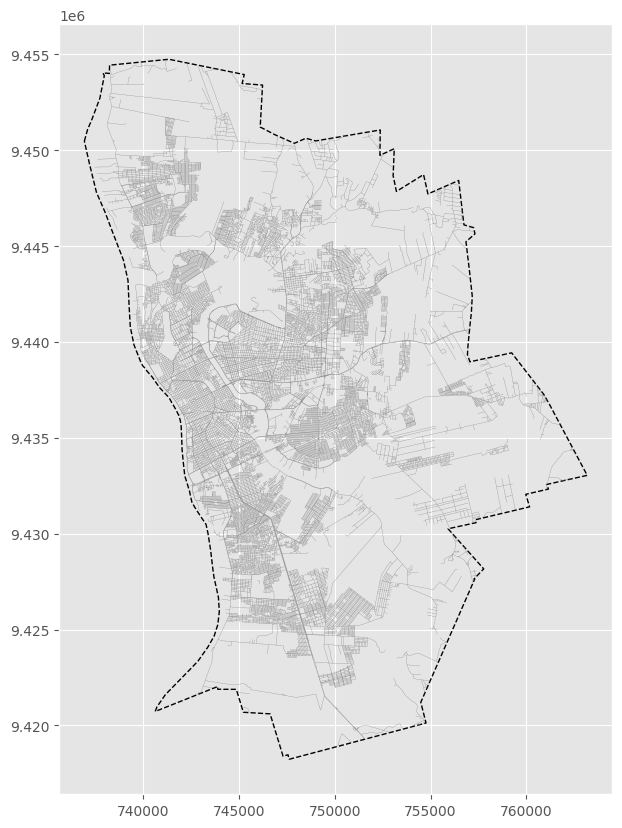

In [68]:
# 1️⃣ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2️⃣ Malha viária — linhas cinza
segments_gdf_ae3km_road_class.plot(ax=ax, color='gray', linewidth=0.2, label='Malha viária')

# 3️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

In [70]:
segments_gdf_ae3km_road_class.to_file(
    "dados/overturemaps/segment_ae3km.geojson", 
    driver='GeoJSON', 
    encoding='utf-8',
)

## Conectores (Nós)

In [71]:
# Vamos realizar um operação espacial de interseção para obter apenas os conectores (nós) dentro da zona urbana 3km
connectors_gdf_ae3km = connectors_gdf_bboxae3km.overlay(area_estudo_buffer3km, how='intersection')

<Axes: >

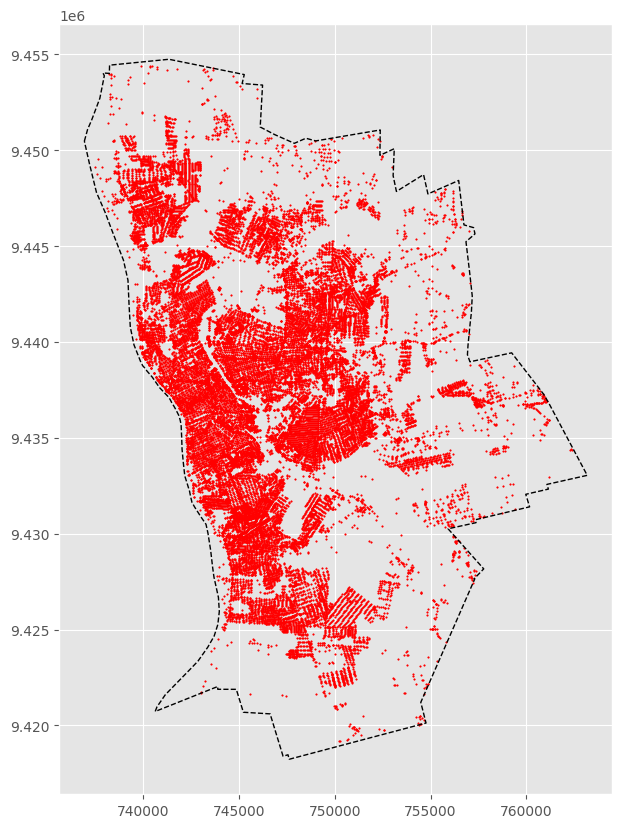

In [72]:
# 1️⃣ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2️⃣ Malha viária — linhas cinza
connectors_gdf_ae3km.plot(ax=ax, color='red', marker='o', markersize=1, label='conectores de trechos')

# 3️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

## Sobrepondo os Nós ao Segmento

<Axes: >

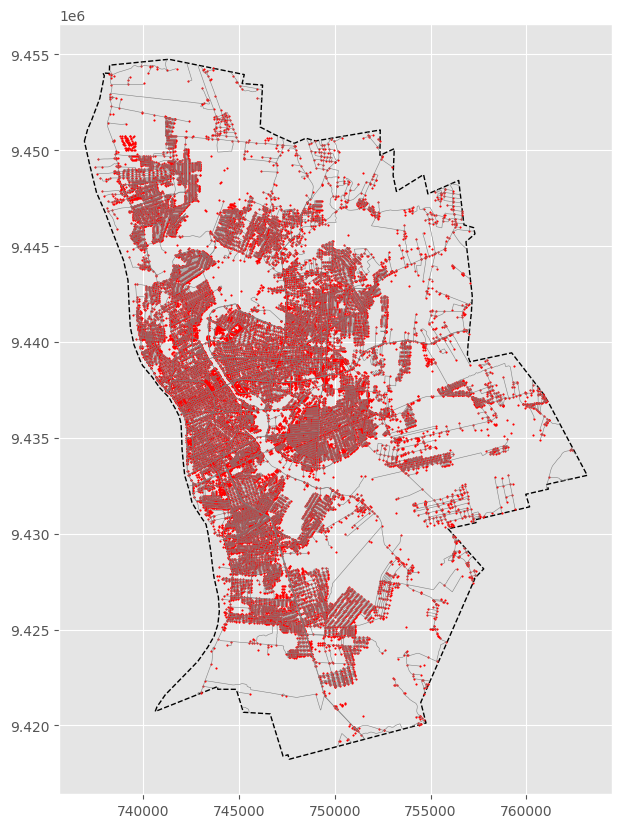

In [73]:
# 1️⃣ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2️⃣ Malha viária — linhas cinza
segments_gdf_ae3km_road_class.plot(ax=ax, color='gray', linewidth=0.4, label='Malha viária')

# 3️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

# 5️⃣ Conectores de Trechos de rua — círculo vermelho
connectors_gdf_ae3km.plot(ax=ax, color='red', marker='o', markersize=1, label='conectores de trechos')

Após a exclusão de alguns segmentos, alguns nó ficaram desconectados da rede. Necessário excluí-los.

In [ ]:
CÓDIGO NÃO UTILIZADO, ESTÁ AQUI APENAS PARA FUTURO APROVEITAMENTO




# --- Pré-requisito: Garantir que ambos os GeoDataFrames tenham o mesmo CRS ---
# Se eles não tiverem o mesmo CRS, a operação falhará.
if connectors_gdf.crs != segments_gdf.crs:
    print("Aviso: Os CRS são diferentes. Projetando os nós para o CRS dos segmentos...")
    connectors_gdf = connectors_gdf.to_crs(segments_gdf.crs)

# --- A Solução ---
print(f"Número de nós ANTES da limpeza: {len(connectors_gdf)}")

# Realiza a junção espacial. Mantém apenas os nós que intersectam a rede de segmentos.
# how='inner': Só mantém os nós que encontram uma rua correspondente.
# predicate='intersects': A regra para a correspondência espacial.
connectors_gdf_zu_ok = gpd.sjoin(connectors_gdf, segments_gdf, how="inner", predicate="intersects")

# --- Limpeza Final ---
# A junção espacial adiciona colunas do GeoDataFrame de segmentos.
# Vamos remover duplicatas caso um nó toque mais de uma rua e manter apenas as colunas originais dos nós.
# Primeiro, obtemos o nome das colunas originais dos nós.
colunas_originais_nos = connectors_gdf.columns

# Remove duplicatas de nós (baseado no índice original) e seleciona as colunas originais
connectors_gdf_zu_ok = connectors_gdf_zu_ok.drop_duplicates(subset='index_right').loc[:, colunas_originais_nos]


print(f"Número de nós APÓS a limpeza: {len(connectors_gdf_zu_ok)}")

# Agora, 'nos_conectados_gdf' contém apenas os pontos que estão conectados à sua rede filtrada.

In [84]:
# Vamos realizar um operação espacial de interseção para obter apenas os conectores (nós) que tocam a rede
print(f"Número total de nó antes da operação {len(connectors_gdf_ae3km)}")
connectors_gdf_ae3km_valid = connectors_gdf_ae3km.overlay(segments_gdf_ae3km_road_class, how='intersection')
# Encontrando pontos duplicados e removendo-os, deixando apenas o último valor
connectors_gdf_ae3km_valid_drop = connectors_gdf_ae3km_valid.drop_duplicates(['id_1'], keep='first')
print(f"Número total de nó depois da operação {len(connectors_gdf_ae3km_valid_drop)} ({len(connectors_gdf_ae3km) - len(connectors_gdf_ae3km_valid_drop)})")

Número total de nó antes da operação 33019
Número total de nó depois da operação 28777 (4242)


<Axes: >

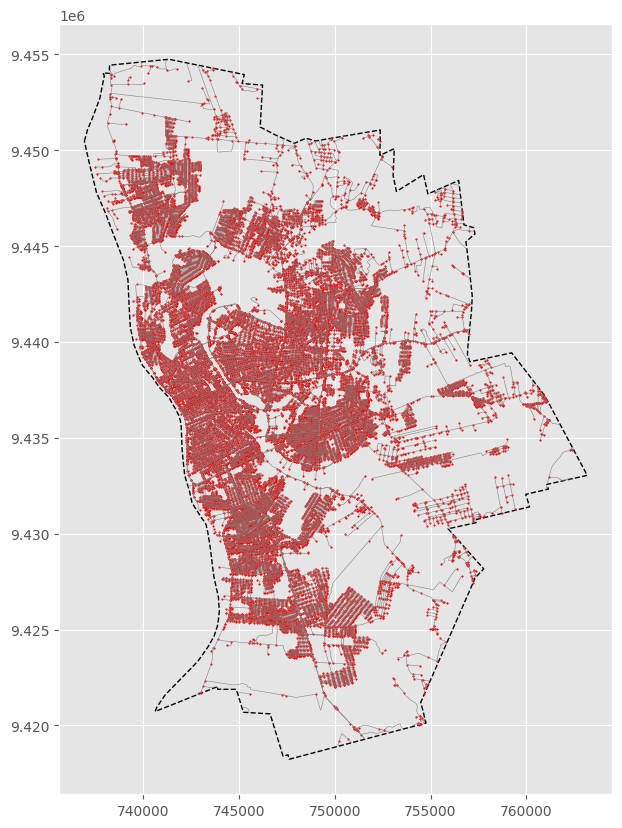

In [86]:
# 1️⃣ --- Figura base ---
fig, ax = plt.subplots(figsize=(10, 10))

# 2️⃣ Malha viária — linhas cinza
segments_gdf_ae3km_road_class.plot(ax=ax, color='gray', linewidth=0.4, label='Malha viária')

# 3️⃣ Área de Estudo Buffer 3 km — contorno preto tracejado
area_estudo_buffer3km.plot(ax=ax, facecolor='none', edgecolor='black', 
                           linewidth=1, linestyle='--', label='Buffer 3 km')

# 5️⃣ Conectores de Trechos de rua — círculo vermelho
connectors_gdf_ae3km_valid_drop.plot(ax=ax, color='red', marker='o', markersize=1, label='conectores de trechos')

In [87]:
connectors_gdf_ae3km_valid_drop.to_file(
    "dados/overturemaps/connectors_ae3km.geojson", 
    driver='GeoJSON', 
    encoding='utf-8'
)

# 3. Street Network Processing

Before creating morphological graphs, we need to process the raw street data. This involves:

1. **Filtering**: Keep only road segments (exclude pedestrian paths, railways, etc.)
2. **Barrier Processing**: Handle bridges and tunnels to create accurate spatial barriers
3. **Network Cleanup**: Ensure proper connectivity for graph operations

The `barrier_geometry` column will contain the processed geometries that act as spatial barriers for tessellation.

In [21]:
buildings_gdf = gpd.read_file("./dados/overturemaps/buildings_ae3km.geojson", columns=['id', 'subtype', 'class', 'geometry'])

segments_gdf = gpd.read_file("./dados/overturemaps/segment_ae3km.geojson", columns=['id', 'subtype', 'class', 'names', 'connectors',
       'routes', 'subclass_rules', 'access_restrictions', 'level_rules',
       'destinations', 'prohibited_transitions', 'road_surface',
       'road_flags', 'speed_limits', 'width_rules', 'subclass', 'geometry'])

connectors_gdf = gpd.read_file("./dados/overturemaps/connectors_ae3km.geojson", columns=["id_1","geometry"])
connectors_gdf = connectors_gdf.rename(columns={'id_1': 'id'})


In [22]:
import pandas as pd
import json

# --- 1. Mapeamentos baseados no Código de Trânsito Brasileiro (CTB) ---

# Dicionário com as velocidades MÁXIMAS legais (em km/h)
speed_max_map_ctb = {
    'trunk': 80.0,        # Via de Trânsito Rápido
    'primary': 60.0,      # Via Arterial
    'secondary': 40.0,    # Via Coletora
    'tertiary': 40.0,     # Via Coletora
    'residential': 30.0,  # Via Local
    'unclassified': 30.0  # Via Local
}

# Dicionário com as velocidades MÍNIMAS legais (metade da máxima)
speed_min_map_ctb = {key: value / 2 for key, value in speed_max_map_ctb.items()}

# Dicionário com as velocidades MÉDIAS REALISTAS para modelagem
speed_avg_map_model = {
    'trunk': 50.0,
    'primary': 40.0,
    'secondary': 30.0,
    'tertiary': 25.0,
    'residential': 20.0,
    'unclassified': 20.0
}


# --- 2. Função para preencher os valores nulos em 'speed_limits' com dados do CTB ---
def preencher_limites_ctb(row):
    """
    Preenche 'speed_limits' nulos com os valores MÁXIMOS e MÍNIMOS do CTB.
    """
    if pd.isna(row['speed_limits']):
        road_class = row['class']
        
        # Pega os valores max e min dos nossos mapas CTB
        max_speed = speed_max_map_ctb.get(road_class, 30.0) # Default de 30 para segurança
        min_speed = speed_min_map_ctb.get(road_class, 15.0) # Default de 15
        
        data_structure = [{
            "min_speed": { "value": min_speed, "unit": "km\\/h" }, # Preenchendo min_speed
            "max_speed": { "value": max_speed, "unit": "km\\/h" },
            "is_max_speed_variable": None,
            "when": None,
            "between": None
        }]
        return json.dumps(data_structure)
    else:
        return row['speed_limits']

# --- 3. Aplicar a função para atualizar a coluna 'speed_limits' ---
print("Preenchendo 'speed_limits' com valores MÁX/MÍN do CTB...")
segments_gdf['speed_limits'] = segments_gdf.apply(preencher_limites_ctb, axis=1)
print("Coluna 'speed_limits' atualizada.")


# --- 4. Criar a nova coluna com a VELOCIDADE MÉDIA para modelagem ---
print("\nCriando coluna de velocidade média para modelagem...")
# A função .map() é uma forma muito eficiente de fazer isso
segments_gdf['velocidade_media_kmh'] = segments_gdf['class'].map(speed_avg_map_model)
# Preencher qualquer valor que não foi mapeado (caso haja uma 'class' inesperada)
segments_gdf['velocidade_media_kmh'].fillna(20.0).copy()
print("Coluna 'velocidade_media_kmh' criada.")

Preenchendo 'speed_limits' com valores MÁX/MÍN do CTB...
Coluna 'speed_limits' atualizada.

Criando coluna de velocidade média para modelagem...
Coluna 'velocidade_media_kmh' criada.


## Check-Point dos dados: Salvar em arquivos físicos:

- segments_gdf_zu
- buildings_gdf_zu

In [23]:
# Extra controle
# ===================================================================
# ===================================================================

# Exportar o GeoDataFrame para o formato GeoJSON
# É uma boa prática especificar a codificação para evitar problemas com caracteres especiais (acentos)
segments_gdf.to_file(
    "dados/overturemaps/segments_ae3km_vel.geojson", 
    driver='GeoJSON', 
    encoding='utf-8',
)

print("Arquivo GeoJSON salvo com sucesso")

Arquivo GeoJSON salvo com sucesso


In [ ]:
# Process segments to handle bridges/tunnels and create proper spatial barriers
segments_gdf_1 = city2graph.process_overture_segments(
    segments_gdf=segments_gdf,
    get_barriers=True,
    connectors_gdf=connectors_gdf,
    threshold=1.0
)

print(f"✅ Processed {len(segments_gdf_1)} road segments")
print("📈 Barrier geometries created for tessellation")

✅ Processed 43899 road segments
📈 Barrier geometries created for tessellation

🔍 Barrier geometry types Barreiras:
   • LineString: 43,818
   • MultiLineString: 75

🔍 Tipos de Geometria dos segmentos:
   • LineString: 43,894
   • MultiLineString: 5


In [39]:
barriers = segments_gdf_1["barrier_geometry"]
segments = segments_gdf_1["geometry"]

# Check the geometry types in the barrier_geometry column
geometry_types = segments_gdf_1["barrier_geometry"].geom_type.value_counts()
print("\n🔍 Barrier geometry types Barreiras:")
for geom_type, count in geometry_types.items():
    print(f"   • {geom_type}: {count:,}")

# Check the geometry types in the barrier_geometry column
geometry_types_2 = segments_gdf_1["geometry"].geom_type.value_counts()
print("\n🔍 Tipos de Geometria dos segmentos:")
for geom_type, count in geometry_types_2.items():
    print(f"   • {geom_type}: {count:,}")

# Check the geometry types in the barrier_geometry column
geometry_types_3 = segments_gdf["geometry"].geom_type.value_counts()
print("\n🔍 Tipos de Geometria dos segmentos:")
for geom_type, count in geometry_types_3.items():
    print(f"   • {geom_type}: {count:,}")


🔍 Barrier geometry types Barreiras:
   • LineString: 43,818
   • MultiLineString: 75

🔍 Tipos de Geometria dos segmentos:
   • LineString: 43,894
   • MultiLineString: 5

🔍 Tipos de Geometria dos segmentos:
   • LineString: 41,241
   • MultiLineString: 5


In [44]:
geometry_types_ubs = ubs_gdf_ae["geometry"].geom_type.value_counts()
print("\n🔍 Tipos de Geometria das UBS:")
for geom_type, count in geometry_types_ubs.items():
    print(f"   • {geom_type}: {count:,}")


🔍 Tipos de Geometria das UBS:
   • Point: 75


## Check-Point dos dados: Salvar em arquivos físicos:

- segments_gdf_barreira

In [32]:
# Extra controle
# ===================================================================
# ===================================================================

# Exportar o GeoDataFrame para o formato GeoJSON
# É uma boa prática especificar a codificação para evitar problemas com caracteres especiais (acentos)
segments_gdf_1.to_parquet(
    "dados/overturemaps/segments_ae3km_vel_split_barreira.parquet"
)

print("Arquivo GeoJSON salvo com sucesso")

Arquivo GeoJSON salvo com sucesso


# 4. Creando Isócronas

In [48]:
print(f"Número de segmentos ANTES de explodir: {len(segments_gdf)}")

# A CORREÇÃO ESTÁ AQUI:
# Adicione ignore_index=True para criar um novo índice limpo (de 0 a N-1)
segments_exploded_gdf = segments_gdf.explode(ignore_index=True)

print(f"Número de segmentos DEPOIS de explodir: {len(segments_exploded_gdf)}")
print("Índice resetado com sucesso!")

Número de segmentos ANTES de explodir: 41246
Número de segmentos DEPOIS de explodir: 41252
Índice resetado com sucesso!


In [46]:
geometry_types_sgments_simples = segments_gdf_simpleLine["geometry"].geom_type.value_counts()
print("\n🔍 Tipos de Geometria das UBS:")
for geom_type, count in geometry_types_sgments_simples.items():
    print(f"   • {geom_type}: {count:,}")


🔍 Tipos de Geometria das UBS:
   • LineString: 41,252


In [ ]:
# --- ETAPA 1: CONFIGURAÇÃO E PREPARAÇÃO DOS DADOS ---

print("--- ETAPA 1: PREPARAÇÃO DOS DADOS DE VELOCIDADE E TEMPO ---")

# Dicionários com as velocidades baseadas no CTB e para o modelo
speed_max_map_ctb = {
    'trunk': 80.0, 'primary': 60.0, 'secondary': 40.0,
    'tertiary': 40.0, 'residential': 30.0, 'unclassified': 30.0
}
speed_min_map_ctb = {key: value / 2 for key, value in speed_max_map_ctb.items()}
speed_avg_map_model = {
    'trunk': 50.0, 'primary': 40.0, 'secondary': 30.0,
    'tertiary': 25.0, 'residential': 20.0, 'unclassified': 20.0
}

# Função para preencher os valores nulos em 'speed_limits' com dados do CTB
def preencher_limites_ctb(row):
    if pd.isna(row['speed_limits']):
        road_class = row['class']
        max_speed = speed_max_map_ctb.get(road_class, 30.0)
        min_speed = speed_min_map_ctb.get(road_class, 15.0)
        data_structure = [{"min_speed": {"value": min_speed, "unit": "km\\/h"},
                           "max_speed": {"value": max_speed, "unit": "km\\/h"},
                           "is_max_speed_variable": None, "when": None, "between": None}]
        return json.dumps(data_structure)
    return row['speed_limits']

# 1.1: Preencher 'speed_limits' com valores MÁX/MÍN do CTB
print("Preenchendo 'speed_limits' com valores do CTB...")
segments_gdf['speed_limits'] = segments_gdf.apply(preencher_limites_ctb, axis=1)

In [ ]:
# 1.2: Criar a coluna de velocidade média para modelagem
print("Criando coluna de velocidade média para modelagem...")
segments_gdf['velocidade_media_kmh'] = segments_gdf['class'].map(speed_avg_map_model)
# Corrigindo o FutureWarning: preencher nulos de forma explícita
segments_gdf['velocidade_media_kmh'] = segments_gdf['velocidade_media_kmh'].fillna(20.0)



In [49]:
# 1.3: Calcular o tempo de viagem em SEGUNDOS a partir da velocidade média
print("Calculando o tempo de viagem em segundos...")
velocidade_ms = segments_gdf['velocidade_media_kmh'] * 1000 / 3600
segments_gdf['tempo_viagem_s'] = segments_gdf.geometry.length / velocidade_ms
print("Dados de tempo de viagem prontos para a análise.")

Calculando o tempo de viagem em segundos...
Dados de tempo de viagem prontos para a análise.


In [53]:
import time

# --- ETAPA 2: CÁLCULO DAS ISÓCRONAS EM LOTE ---

print("\n--- ETAPA 2: CÁLCULO DAS ISÓCRONAS EM LOTE ---")

# Configurações da análise
tempos_minutos = [10.0, 20.0, 30.0]
coluna_tempo_segundos = 'tempo_viagem_s'
resultados_isocronas = []

# Preparação do contador e cronômetro
total_ubs = len(ubs_gdf_ae)
contador_ubs = 0
start_time = time.time()

print(f"Iniciando cálculo para {total_ubs} UBS...")

# Loop principal sobre cada UBS
for index, ubs in ubs_gdf_ae.iterrows():
    contador_ubs += 1
    try:
        # IMPORTANTE: Substitua pelos nomes reais das suas colunas
        nome_ubs = ubs['nome'] 
        id_ubs = ubs['cnes']
    except KeyError:
        nome_ubs = f"UBS_ID_{index}"
        id_ubs = index

    print(f"\n[{contador_ubs}/{total_ubs}] Processando UBS: {nome_ubs}")

    # Loop sobre cada intervalo de tempo
    for tempo_min in tempos_minutos:
        limite_segundos = tempo_min * 60
        try:
            isocrona_gdf = city2graph.create_isochrone(
                graph=segments_exploded_gdf,
                center_point=ubs.geometry,
                distance=limite_segundos,
                edge_attr=coluna_tempo_segundos
            )
            
            if not isocrona_gdf.empty:
                resultados_isocronas.append({
                    'id_ubs': id_ubs,
                    'nome_ubs': nome_ubs,
                    'tempo_min': tempo_min,
                    'geometry': isocrona_gdf.geometry.iloc[0]
                })
                print(f"  - Isócrona de {tempo_min} min calculada.")
            else:
                print(f"  - AVISO: Não foi possível gerar isócrona de {tempo_min} min (ponto isolado?).")
        except Exception as e:
            print(f"  - ERRO ao calcular isócrona de {tempo_min} min: {e}")

# --- ETAPA 3: FINALIZAÇÃO E SALVAMENTO ---

print("\n--- ETAPA 3: FINALIZAÇÃO E SALVAMENTO ---")

end_time = time.time()
tempo_total_seg = end_time - start_time

print(f"Cálculo em lote finalizado!")
print(f"Tempo total de processamento: {tempo_total_seg / 60:.2f} minutos.")


--- ETAPA 2: CÁLCULO DAS ISÓCRONAS EM LOTE ---
Iniciando cálculo para 75 UBS...

[1/75] Processando UBS: UBS A BENICIO FREIRE E SILVA-POTY VELHO
  - Isócrona de 10.0 min calculada.
  - Isócrona de 20.0 min calculada.
  - Isócrona de 30.0 min calculada.

[2/75] Processando UBS: UBS DR. CARLOS ALBERTO CORDEIRO
  - Isócrona de 10.0 min calculada.
  - Isócrona de 20.0 min calculada.
  - Isócrona de 30.0 min calculada.

[3/75] Processando UBS: UBS DR DURVALINO COUTO
  - Isócrona de 10.0 min calculada.
  - Isócrona de 20.0 min calculada.
  - Isócrona de 30.0 min calculada.

[4/75] Processando UBS: UBS DR EVALDO CARVALHO- NOVA BRASILIA
  - Isócrona de 10.0 min calculada.
  - Isócrona de 20.0 min calculada.
  - Isócrona de 30.0 min calculada.

[5/75] Processando UBS: UBS DR FELIPE EULALIO DE PADUA-PROMORAR
  - Isócrona de 10.0 min calculada.
  - Isócrona de 20.0 min calculada.
  - Isócrona de 30.0 min calculada.

[6/75] Processando UBS: UBS DR. FELIX FRANCISCO PEREIRA BATISTA
  - Isócrona de 

In [54]:
# Criar o GeoDataFrame final
isocronas_finais_gdf = gpd.GeoDataFrame(resultados_isocronas, crs=segments_gdf.crs)
print(f"Total de {len(isocronas_finais_gdf)} isócronas geradas com sucesso.")

# Salvar o resultado em um arquivo GeoPackage
caminho_saida = './dados/overturemaps/isocronas_hospitais_resultado.gpkg'
isocronas_finais_gdf.to_file(caminho_saida, driver='GPKG')
print(f"Resultados salvos em: {caminho_saida}")

# Exibir as primeiras linhas do resultado final
display(isocronas_finais_gdf.head())

Total de 225 isócronas geradas com sucesso.
Resultados salvos em: ./dados/overturemaps/isocronas_hospitais_resultado.gpkg


,id_ubs,nome_ubs,tempo_min,geometry
0,2588811,UBS A BENICIO FREIRE E SILVA-POTY VELHO,10.0,"POLYGON ((751539.108 9419271.608, 742838.904 9..."
1,2588811,UBS A BENICIO FREIRE E SILVA-POTY VELHO,20.0,"POLYGON ((751539.108 9419271.608, 742838.904 9..."
2,2588811,UBS A BENICIO FREIRE E SILVA-POTY VELHO,30.0,"POLYGON ((751539.108 9419271.608, 742838.904 9..."
3,6404057,UBS DR. CARLOS ALBERTO CORDEIRO,10.0,"POLYGON ((751539.108 9419271.608, 742838.904 9..."
4,6404057,UBS DR. CARLOS ALBERTO CORDEIRO,20.0,"POLYGON ((751539.108 9419271.608, 742838.904 9..."


In [ ]:
# Set up the figure with a nice size and background
fig, ax = plt.subplots(figsize=(14, 12), facecolor='#f9f9f9')

# Plot central point
ax.scatter(center_point.x, center_point.y, color='black', marker='*', s=200, zorder=5, label='Center Point')

# Plot background elements with improved styling
morpho_nodes["private"].plot(ax=ax, color='#ADD8E6', edgecolor='#87CEEB', linewidth=0.2, alpha=0.2)
morpho_nodes["private"]["building_geometry"].plot(ax=ax, color='#e0e0e0', edgecolor='#c0c0c0', linewidth=0.3, alpha=0.7)
morpho_nodes["public"].plot(ax=ax, color='#404040', linewidth=0.7, alpha=0.6)

# Plot the three network types with distinctive styles
morpho_edges[('private', 'touched_to', 'private')].plot(ax=ax, color='#B22222', linewidth=1.5, alpha=0.7)
morpho_edges[('public', 'connected_to', 'public')].plot(ax=ax, color='#0000FF', linewidth=1.0, alpha=0.7)
morpho_edges[('private', 'faced_to', 'public')].plot(ax=ax, color='#7B68EE', linewidth=1.0, alpha=0.7, linestyle='--')

# Add nodes: private nodes from tessellation centroids (red) and public nodes as midpoints of segments (blue)
private_nodes = morpho_nodes["private"].centroid
ax.scatter(private_nodes.x, private_nodes.y, color='red', s=20, zorder=10, label='Private Spaces')

public_nodes = morpho_nodes["public"].geometry.apply(lambda geom: geom.interpolate(0.5, normalized=True))
ax.scatter(public_nodes.x, public_nodes.y, color='blue', s=20, zorder=10, label='Public Spaces')

# Create a legend with clear labels
legend_elements = [
    plt.Line2D([0], [0], color='black', marker='*', linestyle='None', markersize=10, label='Center Point'),
    plt.Rectangle((0, 0), 1, 1, color='#e0e0e0', label='Buildings'),
    plt.Line2D([0], [0], color='#404040', lw=1.5, label='Street Segments'),
    plt.Rectangle((0, 0), 1, 1, color='#ADD8E6', alpha=0.3, label='Tessellation Cells'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, linestyle='None', label='Private Nodes'),
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, linestyle='None', label='Public Nodes'),
    plt.Line2D([0], [0], color='red', lw=1, label='Private-to-Private'),
    plt.Line2D([0], [0], color='blue', lw=1, label='Public-to-Public'),
    plt.Line2D([0], [0], color='#7B68EE', lw=1, linestyle='--', label='Private-to-Public'),
]

# Position the legend inside the plot (upper right)
ax.legend(handles=legend_elements, loc='upper right',
frameon=True, facecolor='white', framealpha=0.9, fontsize=12)

# Add title and remove axes
ax.set_axis_off()

# Add basemap from Stamen Terrain below everything else
cx.add_basemap(ax, crs='EPSG:27700', source=cx.providers.CartoDB.Positron, alpha=1)

plt.tight_layout()
plt.show()